In [38]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
import datetime as dt
import multiprocessing
import folium
import pylab
import branca
import branca.colormap as cm

from os import walk
from tqdm.notebook import tqdm
from collections import Counter
from folium.plugins import HeatMap
from folium.features import DivIcon

# Single machine progress bar
from dask.diagnostics import ProgressBar

pd.options.display.precision = 2
nbRowsToDisplay = 1000
pd.options.display.min_rows = nbRowsToDisplay
pd.options.display.max_rows = nbRowsToDisplay

In [39]:
fileDirectory = '/mnt/sdb1/gauthier/jupyter/'

# Partition the data by start trip date and sort it by tripStartDate, tripId and gpsRecordedAtUTC

## Evaluate how many trips are overlaping through partitions 

In [255]:
#Load the data
df = dd.read_parquet(fileDirectory+'data/trips-sep-nov-2019',engine='pyarrow')

with ProgressBar():
    #Calculate the number of unique trips
    nbTrips = len(df[['tripId']].drop_duplicates().compute())
    
    #Calculate the sum of the number of unique trips in each partition
    sumTripsOverPartitions = df.map_partitions(lambda df: len(df[['tripId']].drop_duplicates()), meta='int').\
        compute().sum()
    
    #Calculate the difference, which are the trips overlaping through partitions
    print("The overlaping trips represents:", round((sumTripsOverPartitions - nbTrips)/nbTrips*100,2), 
          "% of the total data set.")

[########################################] | 100% Completed | 43.8s
[########################################] | 100% Completed |  1min 22.4s
The overlaping trips represents: 0.12 % of the total data set.


As a result, there is not a big need to repartition the data set such as there is no more trips in several partitions.

## Modify the partition so that trips are sorted by trip start date

In [4]:
#Load the data
df = dd.read_parquet(fileDirectory+'data/trips-sep-nov-2019',engine='pyarrow')

In [3]:
#Change the repartition so that each partition corresponds to a date
#The file CheckRepartition ensures that each partition corresponds to a date
df = df.repartition(npartitions=92)

print(multiprocessing.cpu_count())

#npartitions has to be 4 to 10 times multiprocessing.cpu_count(). So npartitions=92 is good
#Wants several partitions to enable parallel work by the different cores
#Not too many partitions to avoid overhead that occurs after each task

16


In [5]:
df.partitions[1].compute().columns

Index(['carId', 'brand', 'model', 'engineSizeLiters', 'fuelType', 'year',
       'carSegment', 'longitude', 'latitude', 'gpsSpeedFromUnit',
       'gpsDirectionFromUnit', 'gpsRecordedAtUTC', 'tripId',
       'tripStartTimeUTC', 'tripEndTimeUTC', 'tripDriveDurationInMinutes',
       'tripEstimateFuelUsedInLiters', 'tripIdleTimeInSeconds',
       'gpsRecordedAtDate'],
      dtype='object')

In [2]:
def createNewPartitionsSortedByTripStartDate(df_func,startPart,endPart):

    datesList = pd.date_range(start='8/31/2019', end='12/1/2019').strftime("%Y-%m-%d").tolist()

    #Add one day to the true end trips so data for trips overlaping between months can be grouped
    if endPart != 92:
        endPart1 = endPart + 1
    else:
        endPart1 = endPart

    #Select the partition
    df_it = df_func.partitions[startPart:endPart1] 
    nbPartitions = df_it.npartitions

    #Sort by trip start date, tripId and time
    with ProgressBar():
        df_it = df_it.assign(tripStartDate = df_it.tripStartTimeUTC.dt.date)
        df_it = df_it.compute()

    df_it = df_it.set_index(['tripStartDate','tripId','gpsRecordedAtUTC']).sort_index()

    
    #Write a parquet file for each start trip date
    
    #The start partition is one day before for the first month. For the next months, the trips that have begun 
    #before the current month are already included in the previous partitions.
    if startPart != 0:
        startPart1 = startPart + 1
    else:
        startPart1 = startPart

    if endPart1==92:
        endPart1 +=1

    #Write the parquet files
    for date in datesList[startPart1:endPart1]: #Due to the first date all time slots are shifted by one
        #print(date)
        df_it1 = df_it.loc[date].reset_index() 
        df_it1['tripId'] = df_it1.tripId.cat.remove_unused_categories() #VERY IMPORTANT: Remove the unused categories
        df_it1.to_parquet("data/DataUnderstanding/sortedStartDateTripsTime-trips-sep-nov-2019/startTripDate-" + date + ".parquet")

In [262]:
#Partition the data by start trip date
startPartition = [0, 15, 30, 45, 61, 75] #Start days for partitions
endPartition = [15, 30, 45, 61, 75, 92] 

#Iterate over the first 1.5 month 
for i in tqdm(range(3)): #range(3,6) for the last 1.5 month
    start = startPartition[i]
    end = endPartition[i]
    
    createNewPartitionsSortedByTripStartDate(df,start,end)

  0%|          | 0/3 [00:00<?, ?it/s]

[########################################] | 100% Completed | 23.6s
The data is correctly ordered
[########################################] | 100% Completed | 43.1s
The data is correctly ordered
[########################################] | 100% Completed | 43.7s
The data is correctly ordered


# Read the sorted data and prepare it

The data is sorted at 3 levels tripStartDate, TripId and gpsRecordedAtUTC. The haversine distances can therefore be calculated on the sorted data with a fast vectorised function. 

In [2]:
#The kernel keeps dying when working on the whole dataset
#Load the data
df = dd.read_parquet('data/DataUnderstanding/sortedStartDateTripsTime-trips-sep-nov-2019',engine='pyarrow') 

In [3]:
df.npartitions #nb of start trip dates - should be 93

93

In [3]:
# Vectorized haversine function to calculate distances
#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def haversineDf(df):
    Lat = [np.nan]
    Lat[1:] = df.latitude[1:]
    Long = [np.nan]
    Long[1:] = df.longitude[1:]
    dist = haversine(df.latitude.shift(), df.longitude.shift(),Lat, Long)
    
    return dist 

In [5]:
def prepareData_TimeDistancesEndPoints(df_func,monthNb):
    with ProgressBar():
        datesList = pd.date_range(start='8/31/2019', end='12/1/2019').strftime("%Y-%m-%d").tolist()
        startPartition = [0, 31, 62] #Start days for partitions
        endPartition = [31, 62, 93]  
        
        startPart = startPartition[monthNb]
        endPart = endPartition[monthNb]

        #Select the partition
        df_it = df_func.partitions[startPart:endPart] 
        nbPartitions = df_it.npartitions

        #Convert UTC datetime to CET datetime
        df_it = df_it.assign(hoursFromUTCtoCET = (df_it.gpsRecordedAtUTC <= dt.datetime(2019,10,27,3,0,0)).astype('int') + 1)
        df_it = df_it.map_partitions(lambda df: df.assign(gpsRecordedAtCET = df.gpsRecordedAtUTC + 
                                                          pd.to_timedelta(df.hoursFromUTCtoCET,unit='h')))
        df_it = df_it.assign(hourCET = df_it.gpsRecordedAtCET.dt.hour)

        #Calculate the travel distance between records
        df_it = df_it.map_partitions(lambda df: df.assign(travelDistanceInKm=haversineDf(df))) 

        #Assign null distance for each new starting point of a trip
        df_it = df_it.map_partitions(lambda df: df.assign(notNewTrip=(df.tripId.shift() == df.tripId).astype(int))) 
        df_it = df_it.assign(travelDistanceInKm = df_it.notNewTrip * df_it.travelDistanceInKm)
        
        #Add the cumulative distances
        df_it = df_it.map_partitions(lambda df: \
            df.assign(travelDistanceInKmCumSum = df[['tripId','travelDistanceInKm']].groupby(['tripId']).cumsum()))

        #Add the start and end point to the data
        df_it['startPoint'] = (~df_it.notNewTrip.astype('bool')).astype('int')
        df_it['endPoint'] = df_it.startPoint.shift(periods=-1).fillna(1) #The last row is considered a trip end
        
        #Drop the unnecessary columns
        df_it = df_it.drop(columns=['hoursFromUTCtoCET','newPartition','notNewTrip'])
        
        #Check that there are only one start date by partition
        df_uniqueDates = df_it.map_partitions(lambda df: df.loc[:,['tripStartDate','engineSizeLiters']].\
                                              groupby('tripStartDate').min().index.values)
        df_uniqueDates = df_uniqueDates.compute()
        #print("Dates in the partition:",df_uniqueDates)
            
        #Is the data still sorted by trip start date?
        print("The data is sorted by trip start date:",
              (df_it.tripStartDate.shift() != df_it.tripStartDate).astype('int').sum().compute()==df_it.npartitions)

        #Write the partitions one date by one
        for j in range(df_it.npartitions):
            date = datesList[startPart + j]
            df_it1 = df_it.partitions[j].compute()
            df_it1.to_parquet("data/DataUnderstanding/prepared-trips-sep-nov-2019/startTripDate-" + date + '.parquet')

In [7]:
#Prepare the first month data
prepareData_TimeDistancesEndPoints(df,0)

In [8]:
#Prepare the 2nd month data
prepareData_TimeDistancesEndPoints(df,1)

In [9]:
#Prepare the third month data
prepareData_TimeDistancesEndPoints(df,2)

# Assess how much trips have missing values

In [10]:
#Load the data
df = dd.read_parquet('data/DataUnderstanding/prepared-trips-sep-nov-2019',engine='pyarrow') 

df.npartitions

93

In [38]:
%time print("% of trips missing TravelDistance:", len(df[np.isnan(df.travelDistanceInKm)==True])/len(df))

% of trips missing TravelDistance: 4.3726555337352206e-07
CPU times: user 1min 27s, sys: 56 s, total: 2min 23s
Wall time: 1min


# Basic statistics

In [14]:
#Load the data
#df = dd.read_parquet(allFiles,engine='pyarrow')

#Load the data
df = dd.read_parquet('data/DataUnderstanding/prepared-trips-sep-nov-2019',engine='pyarrow') 

In [41]:
#Nb of records
%time print("Number of records:",len(df))

Number of records: 212685402
CPU times: user 12.2 s, sys: 3.46 s, total: 15.7 s
Wall time: 2.73 s


In [42]:
#Nb of cars
%time print('Nb of cars:',len(df[['carId']].drop_duplicates().compute()))

Nb of cars: 40649
CPU times: user 22.3 s, sys: 3.04 s, total: 25.3 s
Wall time: 2.3 s


In [43]:
#Nb of trips
nbTrips = len(df[['tripId']].drop_duplicates().compute())
%time print("Nb of trips:",nbTrips)

Nb of trips: 2348695
CPU times: user 105 µs, sys: 47 µs, total: 152 µs
Wall time: 113 µs


In [44]:
#Nb of trips with fuel estimates
%time print("Nb of records with estimate fuel used:", len(df.tripEstimateFuelUsedInLiters.dropna()))

Nb of records with estimate fuel used: 170296554
CPU times: user 12.8 s, sys: 2.22 s, total: 15 s
Wall time: 2.69 s


# Data preparation at the trip level for data visualisation

In [64]:
#Load the data
df = dd.read_parquet('data/DataUnderstanding/prepared-trips-sep-nov-2019',engine='pyarrow') 

In [27]:
#Compute the required calculations beforehand
with ProgressBar():
    #Nb of trips by weekday
    df = df.assign(weekday=df.gpsRecordedAtUTC.dt.weekday)
    
    #Nb of trips by date
    df = df.assign(gpsRecordedAtDate=df.gpsRecordedAtUTC.dt.date)
    
    #Works as trips are not overlaping through partitions 
    dfTrips = df.map_partitions(lambda df: df.groupby('tripId').agg({'weekday':'min', 'gpsRecordedAtDate':'min',
                                'tripEstimateFuelUsedInLiters':'min','tripDriveDurationInMinutes':'min',
                                'engineSizeLiters':'count','hourCET':'min','travelDistanceInKmCumSum':'max',
                                'gpsRecordedAtCET':'min','carId':'min'})
                                       ,
                                 meta=df[['weekday','gpsRecordedAtDate','tripEstimateFuelUsedInLiters',
                                           'tripDriveDurationInMinutes','engineSizeLiters','hourCET',
                                          'travelDistanceInKmCumSum','gpsRecordedAtCET','carId']])
    
    #Rename the travel distance
    dfTrips = dfTrips.rename(columns={'travelDistanceInKmCumSum':'totalTravelDistanceInKm','engineSizeLiters':"nbRecords"})
    
    dfTrips = dfTrips.compute()

[########################################] | 100% Completed |  8min 16.8s


In [28]:
#dfTrips.to_pickle('data/DataUnderstanding/dataAggregatedByTrips')

# Data understanding: trips in time (depending on dates, weekdays, hour)

In [40]:
def computeHistogram(values):
    c=Counter(values)
    counts = list(c.values())
    labels = list(c.keys())
    
    return counts, labels

def plotHistogram(counts,labels,tit,xlab,ylab):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    ax.bar(labels, counts, align='center')
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)
    
#Define a plot histrogram function
def plotContinuousHist(serie,nbBins,tit,xlab,ylab):
    #Distribution of trip duration
    df = pd.DataFrame(serie)
    df.hist(bins=nbBins,figsize=(20,10))
    plt.title(tit,fontsize=18)
    plt.xlabel(xlab,fontsize=18)
    plt.ylabel(ylab,fontsize=18)
    
#Define a scatter plot function
def scatterPlot(x,y,tit,xlab,ylab):
    fig = pylab.figure(figsize=(20,10))    
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x,y)
    ax.set_title(tit, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylabel(ylab, fontsize=18)
    ax.grid(True)
    ax.set_axisbelow(True)

In [41]:
#Load the data
dfTrips = pd.read_pickle(fileDirectory+'data/DataUnderstanding/dataAggregatedByTrips')

#Select a subset
#dfTrips = dfTrips[:100000]

In [36]:
print("% of lost traveled distance due to randomisation:",
      round(len(dfTrips)*0.5*2/dfTrips.totalTravelDistanceInKm.sum()*100,2))

% of lost traveled distance due to randomisation: 5.81


Avg consumption: 9.52885869965355
% trips with more than 30L/ 100km: 0.03031935560417324


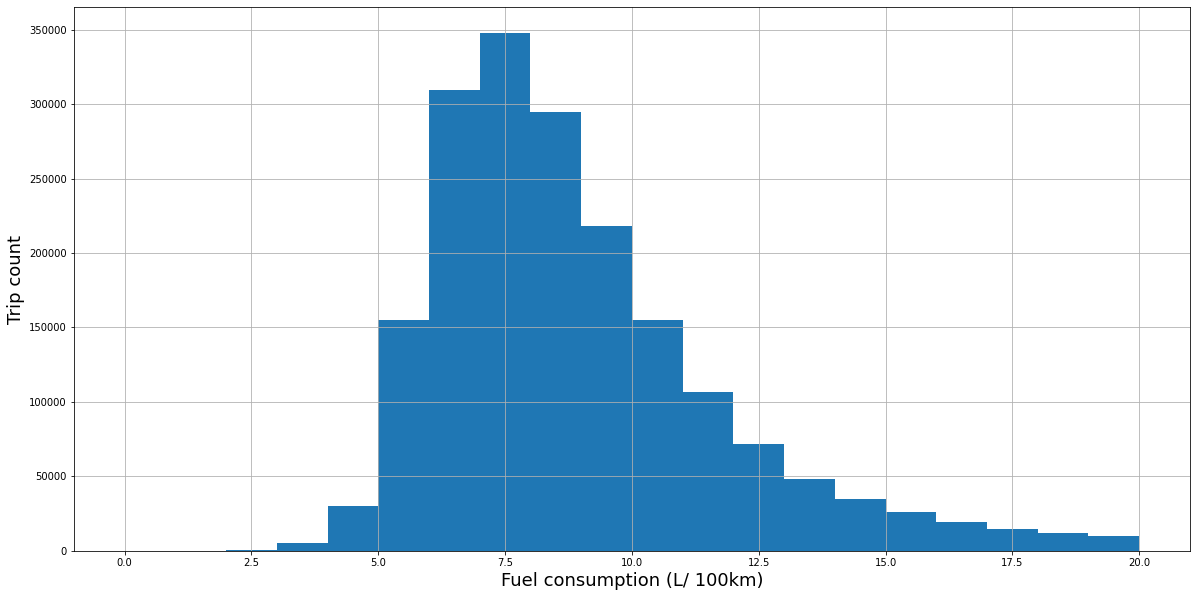

In [37]:
dfTrips['fuelConsumption']=dfTrips.tripEstimateFuelUsedInLiters/dfTrips.totalTravelDistanceInKm*100
dfTrips=dfTrips[dfTrips.fuelConsumption<100]
print('Avg consumption:',dfTrips.fuelConsumption.mean())
print("% trips with more than 30L/ 100km:",len(dfTrips[dfTrips.fuelConsumption>20])/len(dfTrips))
dfTrips=dfTrips[dfTrips.fuelConsumption<20]
plotContinuousHist(dfTrips.fuelConsumption,20,'','Fuel consumption (L/ 100km)','Trip count')

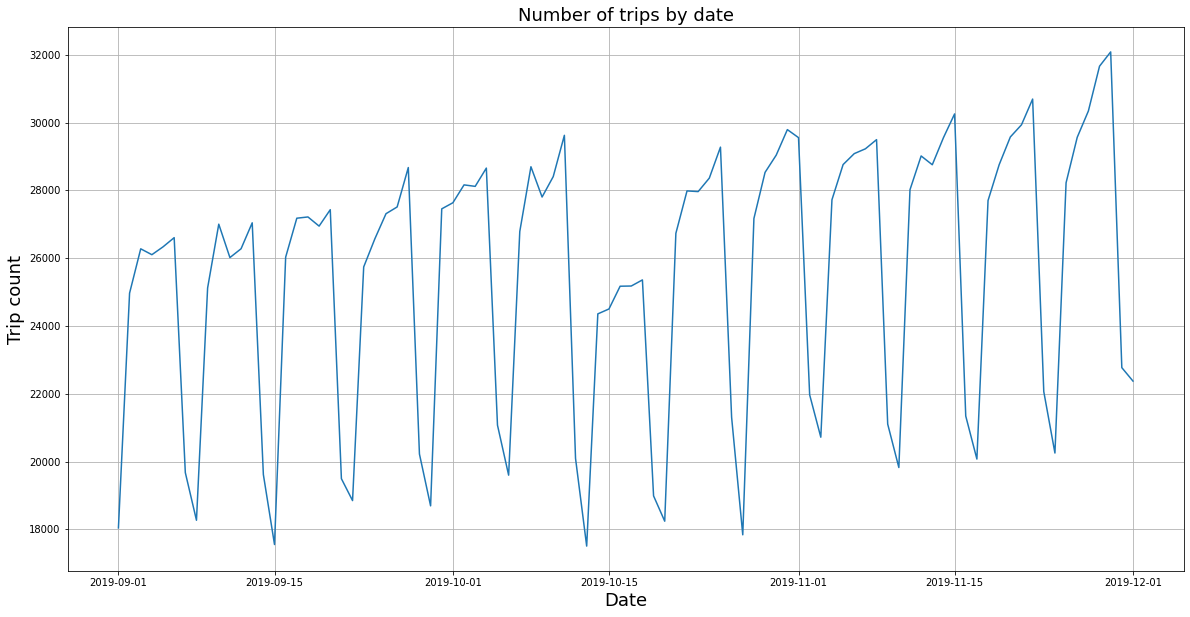

In [48]:
#Nb of data rows by date - clear drop of trip during the weekend
dfTrips = dfTrips.sort_values(by=['gpsRecordedAtDate']) #Sort the values by date
dateCounts, dateLabels = computeHistogram(dfTrips.gpsRecordedAtDate)

#Nb of data rows by date - clear drop of trip during the weekend
#dfTrips = dfTrips.sort_values(by=['gpsRecordedAtDate']) #Sort the values by date
#dateCounts, dateLabels = computeHistogram(dfTrips.gpsRecordedAtDate)

fig = pylab.figure(figsize=(20,10))    
ax = fig.add_subplot(1,1,1)
ax.plot(dateLabels, dateCounts)
ax.set_title("Number of trips by date", fontsize=18)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("Trip count", fontsize=18)
ax.grid(True)
ax.set_axisbelow(True)

The drop of trips from the 12/10/2019 to 19/10/2019 corresponds to Autumn holidays.

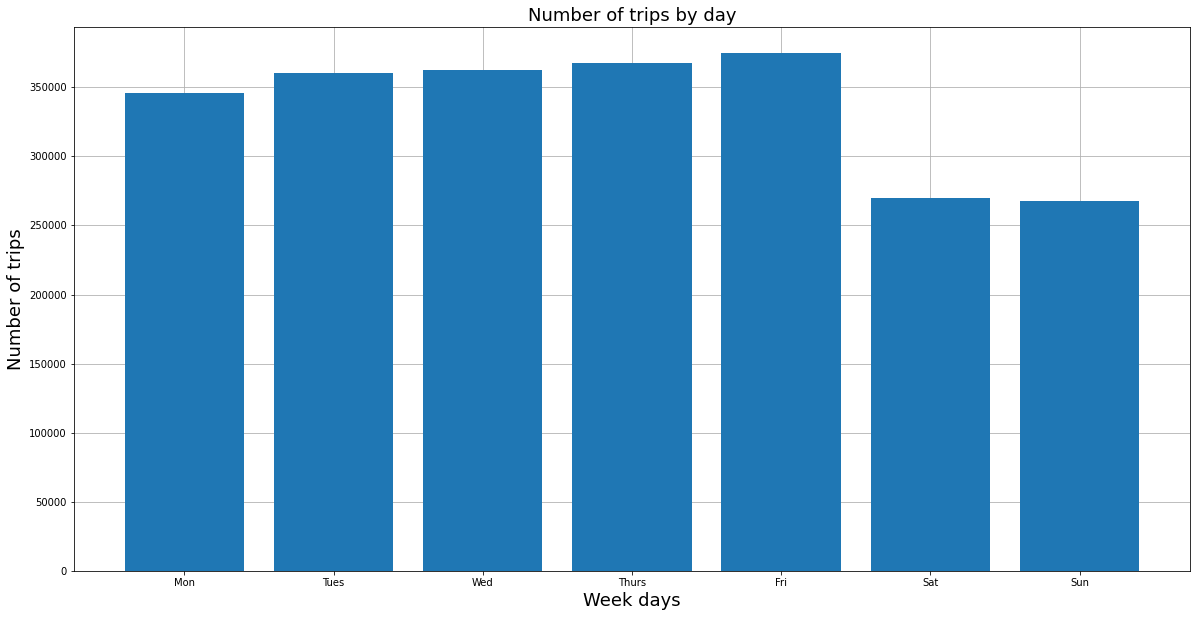

In [74]:
tripCounts, dayLabels = computeHistogram(dfTrips.weekday) 

#Relabel
newlabels={0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
dayLabels =[newlabels[x] for x in dayLabels]

#Put sunday as the last element of the histogram
dayLabels = dayLabels[1:] + [dayLabels[0]]
tripCounts = tripCounts[1:] + [tripCounts[0]]

plotHistogram(tripCounts, dayLabels,'Number of trips by day','Week days','Number of trips')

#There are less trips in the week-end

CPU times: user 2min 53s, sys: 40.2 s, total: 3min 33s
Wall time: 3min 53s


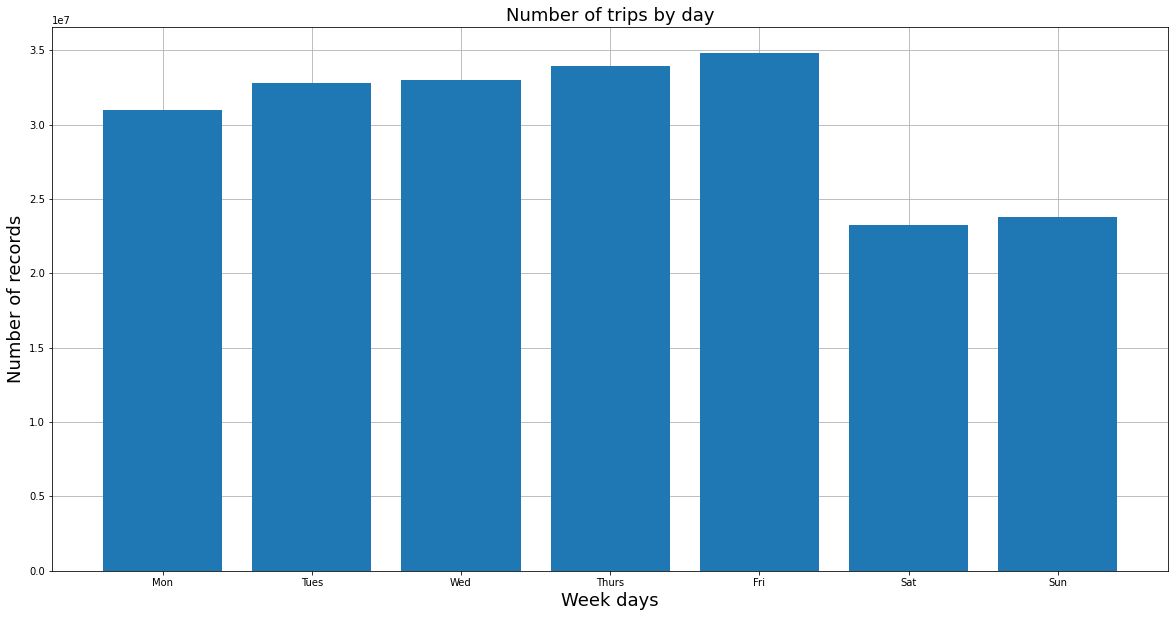

In [75]:
#Nb of data rows by day - similar results than before
#Takes few minutes
%time recordCounts, dayLabels = computeHistogram(df.weekday)

#Relabel
dayLabels=[newlabels[x] for x in dayLabels]

#Put sunday as the last element of the histogram
dayLabels = dayLabels[1:] + [dayLabels[0]]
recordCounts = recordCounts[1:] + [recordCounts[0]]

#Plot
plotHistogram(recordCounts, dayLabels,'Number of trips by day','Week days','Number of records')

CPU times: user 3min 10s, sys: 35.7 s, total: 3min 45s
Wall time: 3min 37s


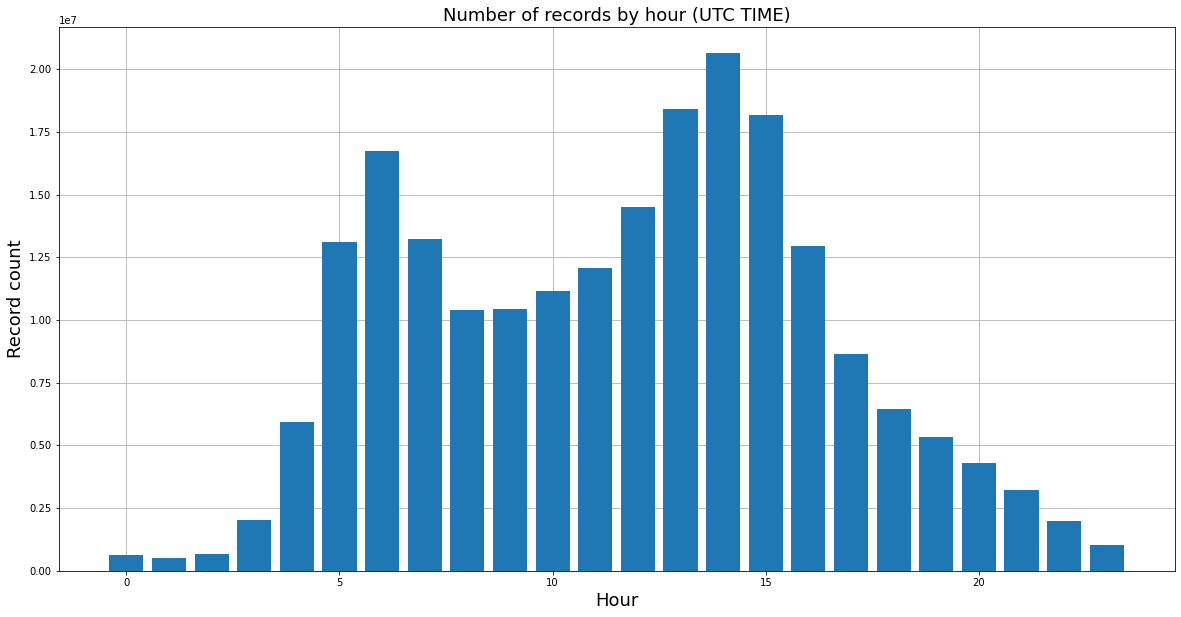

In [76]:
#Nb of data rows by hour
#Takes 5min
with ProgressBar():
    df = df.assign(hour=df.gpsRecordedAtUTC.dt.hour)

%time hourCounts, hourLabels = computeHistogram(df.hour)

plotHistogram(hourCounts, hourLabels,'Number of records by hour (UTC TIME)','Hour','Record count')

CPU times: user 56.9 s, sys: 3.62 s, total: 1min
Wall time: 1min 4s


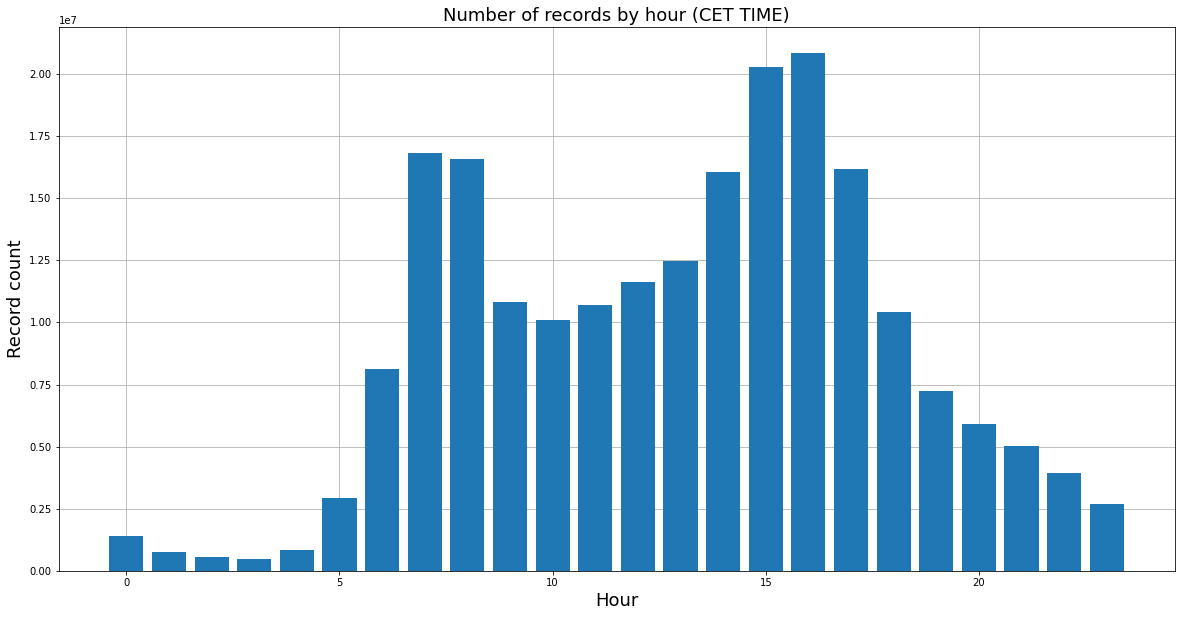

In [66]:
%time hourCETCounts, hourCETLabels = computeHistogram(df.gpsRecordedAtCET.dt.hour)

plotHistogram(hourCETCounts, hourCETLabels,'Number of records by hour (CET TIME)','Hour','Record count')

CPU times: user 555 ms, sys: 10.7 ms, total: 566 ms
Wall time: 555 ms


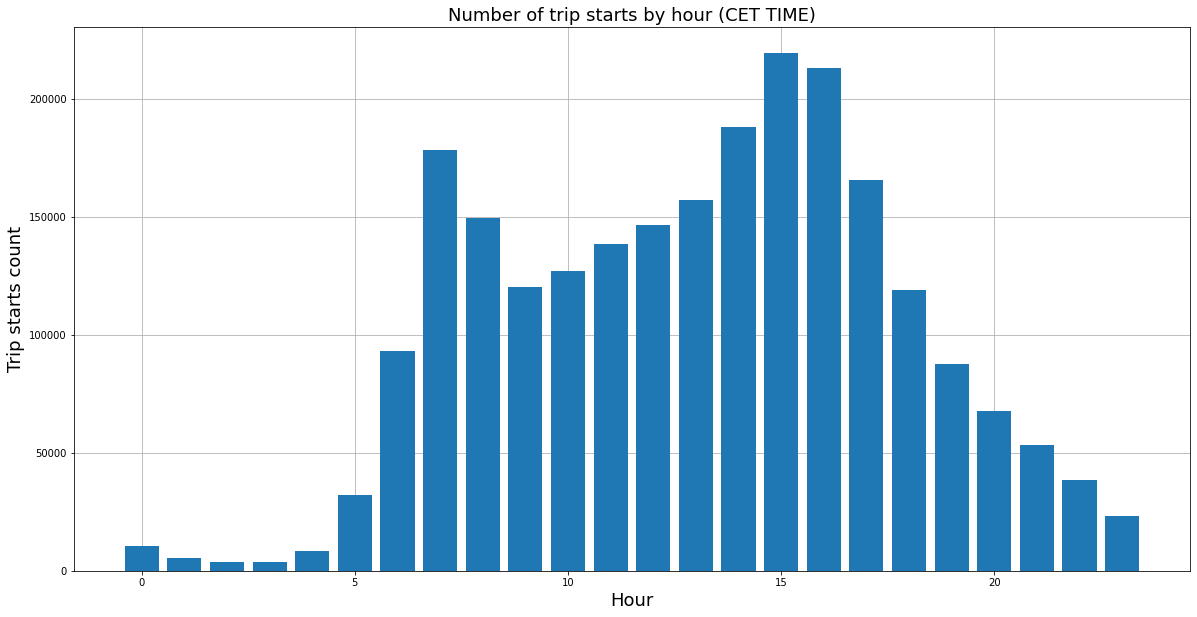

In [67]:
%time hourCETByTripCounts, hourCETByTripLabels = computeHistogram(dfTrips.gpsRecordedAtCET.dt.hour)

plotHistogram(hourCETByTripCounts, hourCETByTripLabels,'Number of trip starts by hour (CET TIME)','Hour','Trip starts count')

# Fuel used

In [55]:
#Mean fuel used
print("Average fuel used by trip:",round(dfTrips.tripEstimateFuelUsedInLiters.mean(),2))

Average fuel used by trip: 1.32


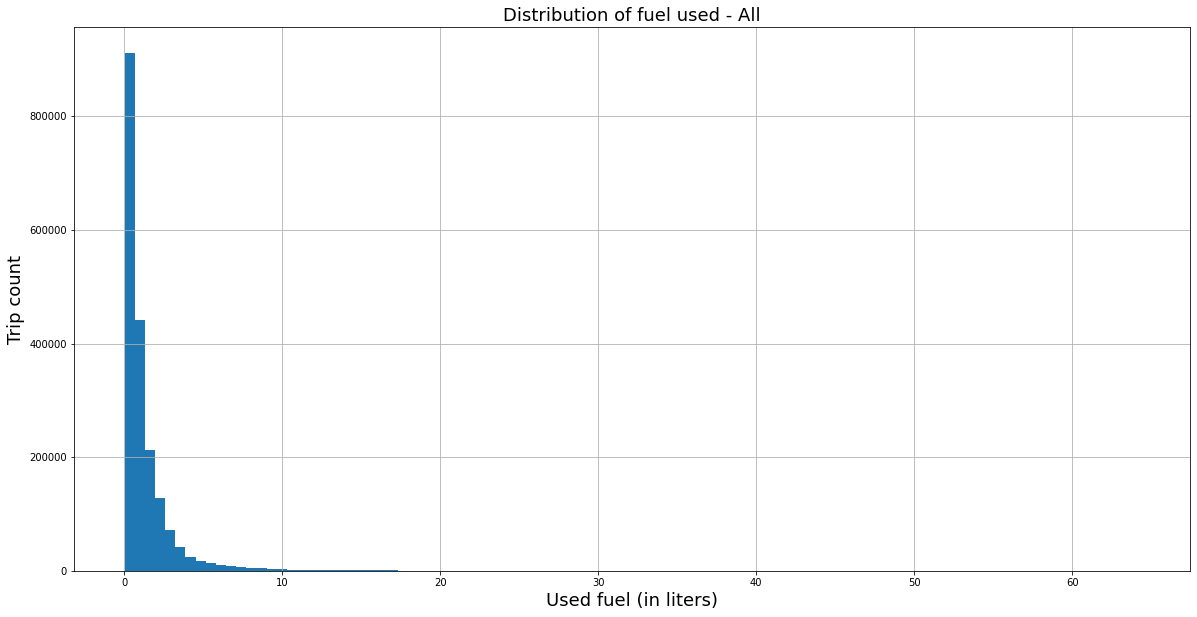

In [56]:
#Distribution of used fuel by trip
#Most of the trips use between 0-10 liters and more specifically 0-2 liters 
plotContinuousHist(dfTrips.tripEstimateFuelUsedInLiters,100,
                   'Distribution of fuel used - All',"Used fuel (in liters)","Trip count")

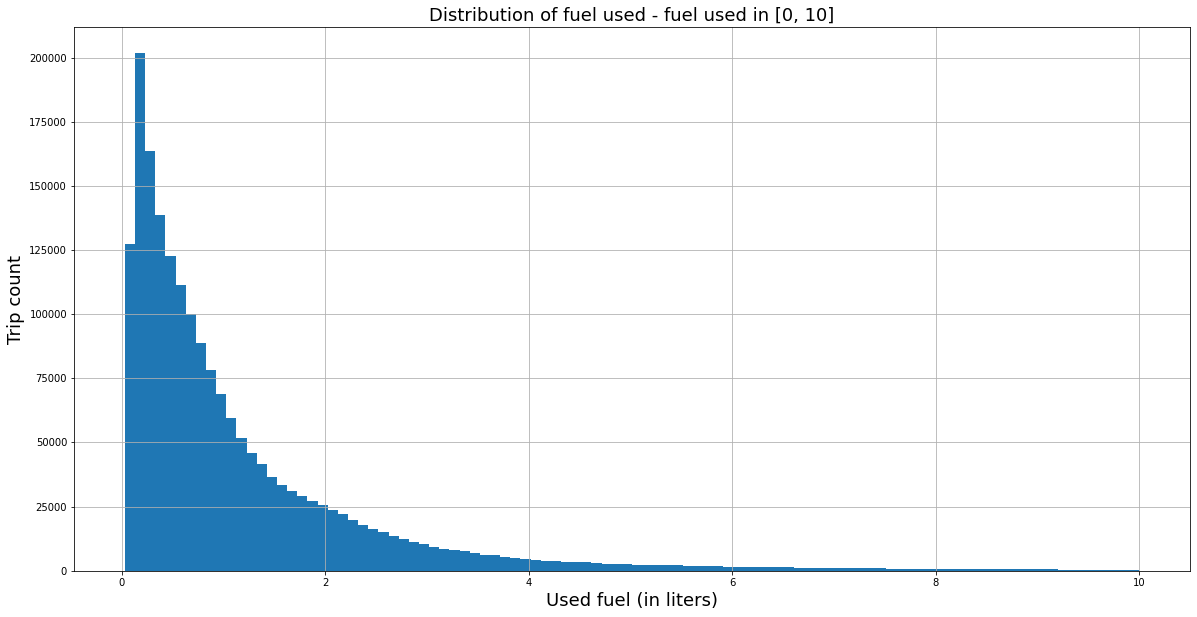

In [57]:
plotContinuousHist(dfTrips.tripEstimateFuelUsedInLiters[dfTrips.tripEstimateFuelUsedInLiters<10],100,
                   'Distribution of fuel used - fuel used in [0, 10]',"Used fuel (in liters)","Trip count")

# Distances 

In [108]:
#Mean trip distance
print("Average trip distance in km:",np.floor(dfTrips[dfTrips.totalTravelDistanceInKm<1000].totalTravelDistanceInKm.mean()))

Average trip distance in km: 17.0


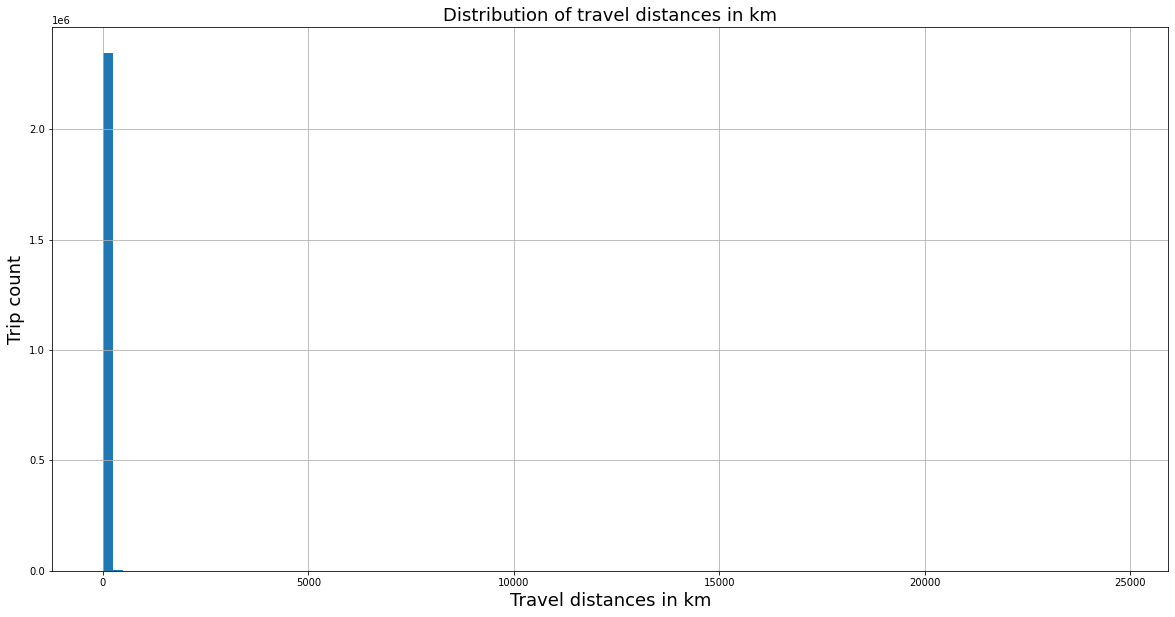

In [109]:
plotContinuousHist(dfTrips.totalTravelDistanceInKm,100,
                  "Distribution of travel distances in km",'Travel distances in km','Trip count')

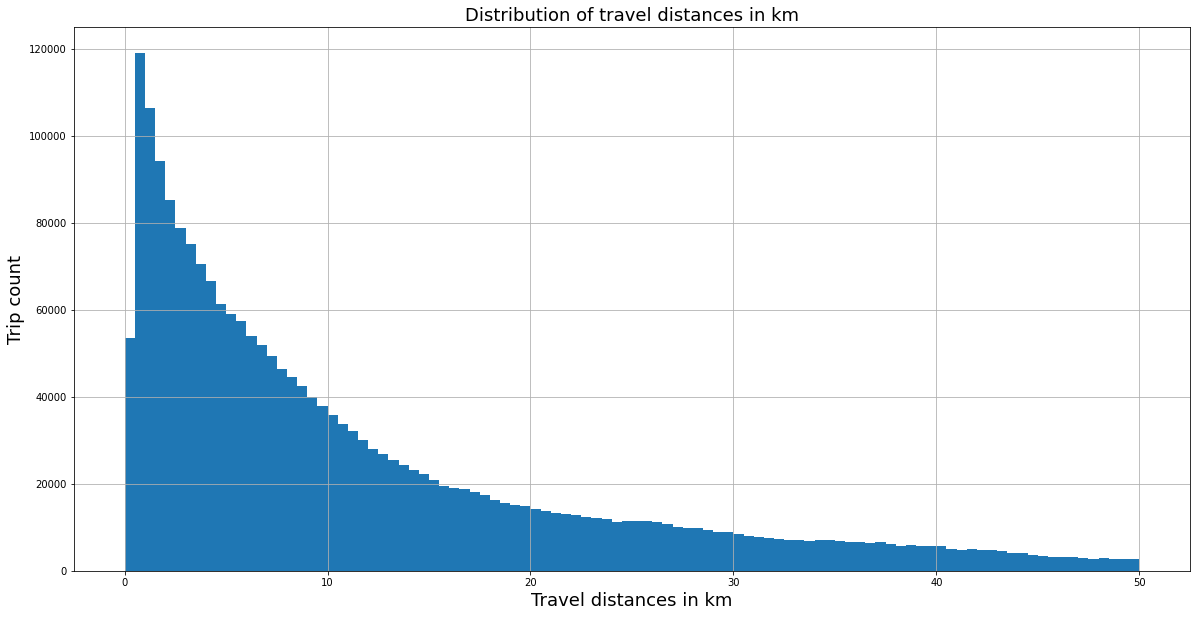

In [60]:
plotContinuousHist(dfTrips[dfTrips.totalTravelDistanceInKm<50].totalTravelDistanceInKm,100,
                  "Distribution of travel distances in km",'Travel distances in km','Trip count')

There is a mode of 2 km for the trip distances. There are some outliers going up to 25000km.

# Distances vs fuel used 

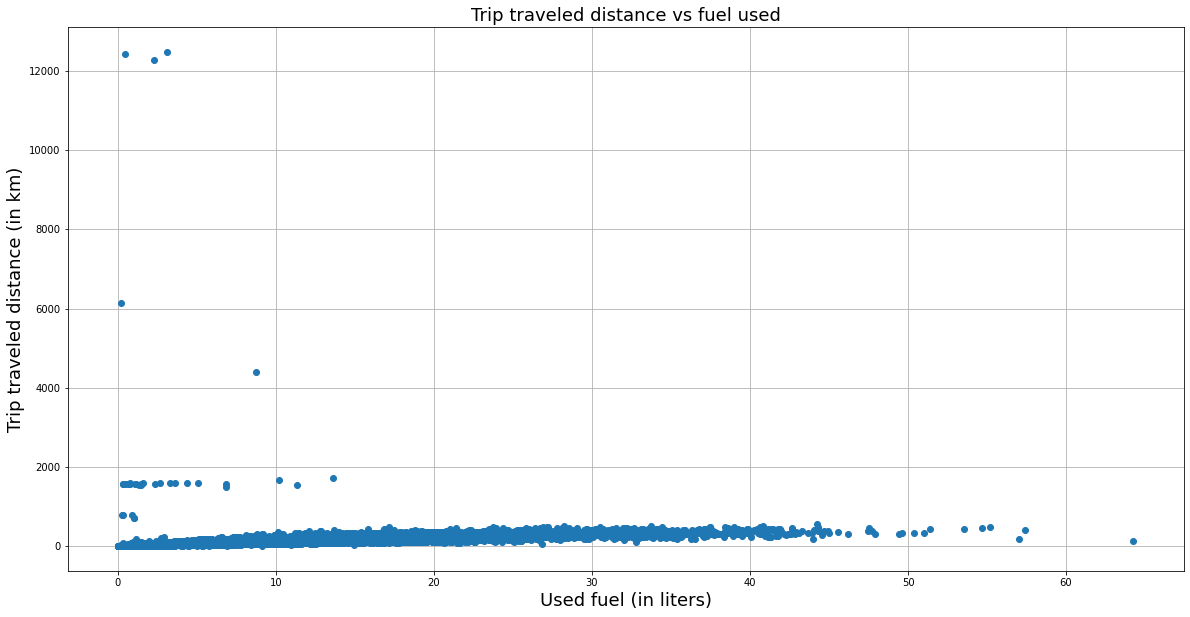

In [49]:
#Plot the fuel used by trip vs trip drive duration

#Remove the trips with NaN estimateFuelUsedInLiters
dfTripsNoNa = dfTrips.dropna(how='any')

scatterPlot(dfTripsNoNa.tripEstimateFuelUsedInLiters,dfTripsNoNa.totalTravelDistanceInKm,
            'Trip traveled distance vs fuel used',"Used fuel (in liters)","Trip traveled distance (in km)")

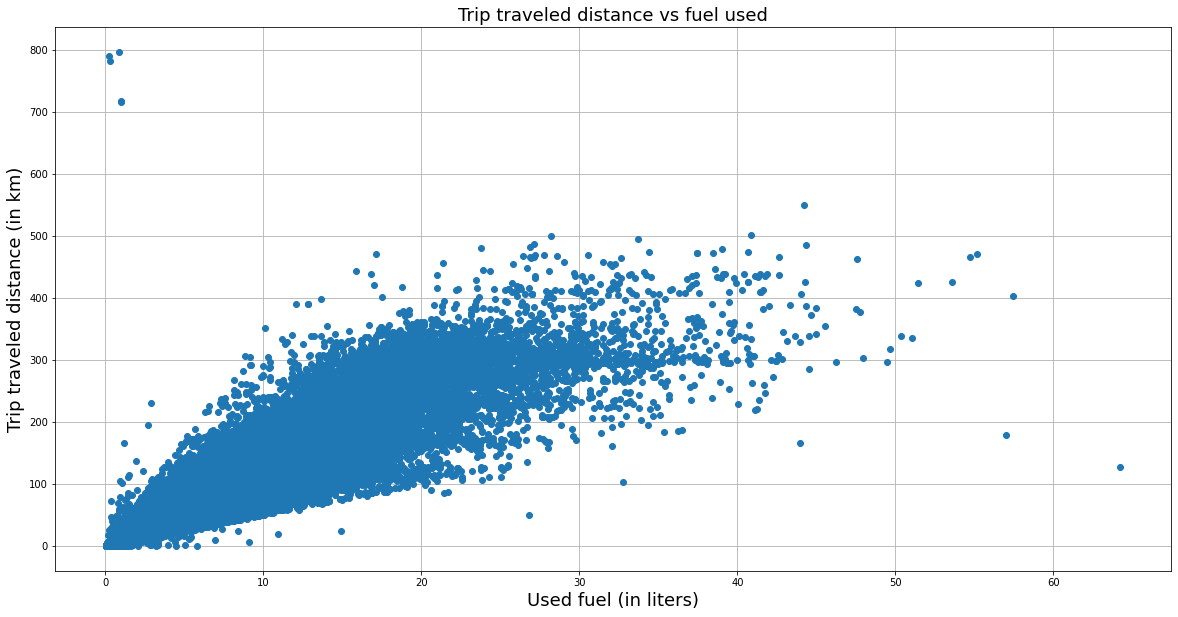

In [50]:
#Plot the fuel used by trip vs trip drive duration

#Takes few minutes
scatterPlot(dfTripsNoNa[dfTripsNoNa.totalTravelDistanceInKm<1000].tripEstimateFuelUsedInLiters,
            dfTripsNoNa[dfTripsNoNa.totalTravelDistanceInKm<1000].totalTravelDistanceInKm,
            'Trip traveled distance vs fuel used',"Used fuel (in liters)","Trip traveled distance (in km)")

Apart from very few outliers, the traveled distance can be approximated by a linear function of used fuel.

# Drive duration 

In [62]:
#Mean trip duration
print("Average trip duration:",np.floor(dfTrips.tripDriveDurationInMinutes.mean()))

Average trip duration: 25.0


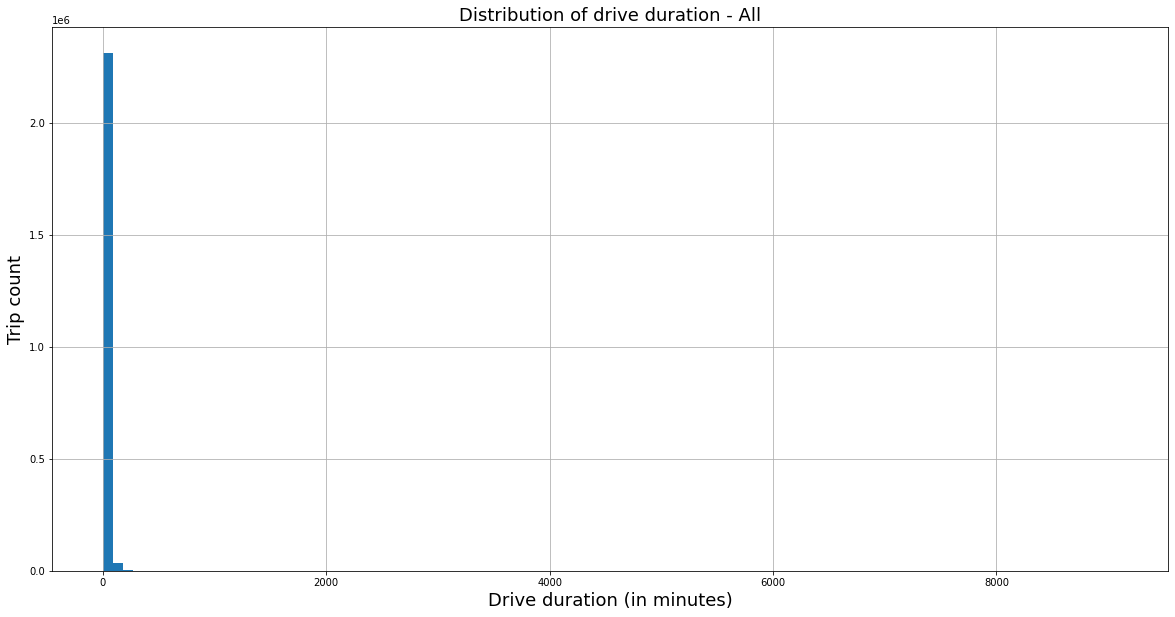

In [63]:
#Distribution of trip duration
plotContinuousHist(dfTrips.tripDriveDurationInMinutes,100,
                   'Distribution of drive duration - All',"Drive duration (in minutes)","Trip count")

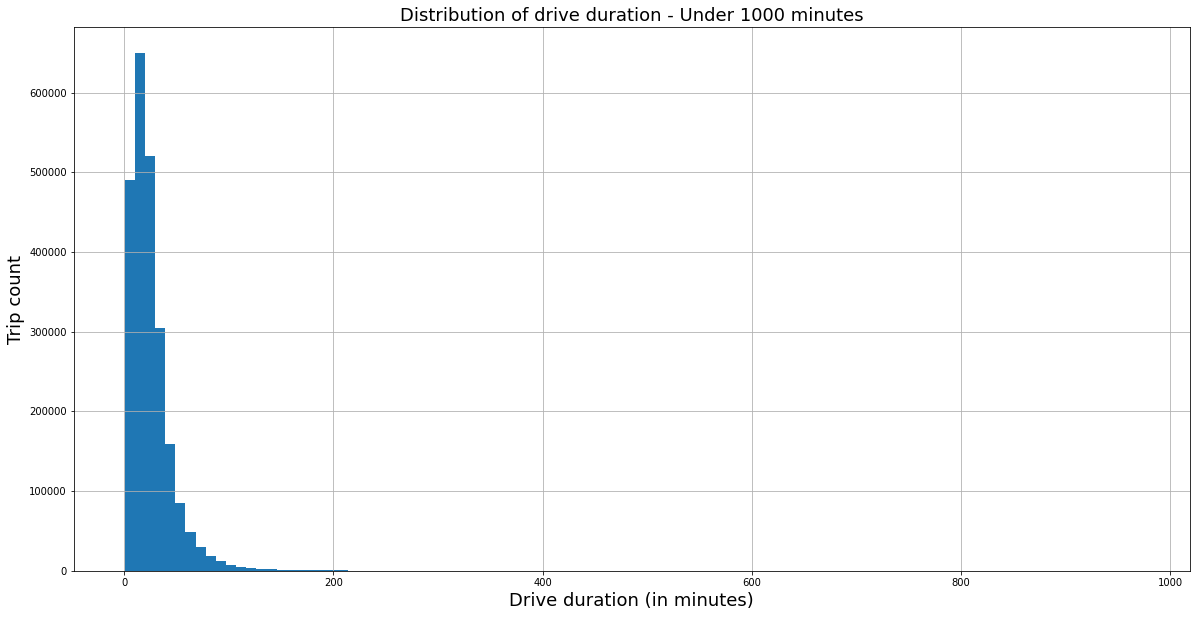

In [64]:
#Drive durations above 1000 are clearly outliers
plotContinuousHist(dfTrips[dfTrips.tripDriveDurationInMinutes<1000].tripDriveDurationInMinutes,100,
                   'Distribution of drive duration - Under 1000 minutes',"Drive duration (in minutes)","Trip count")

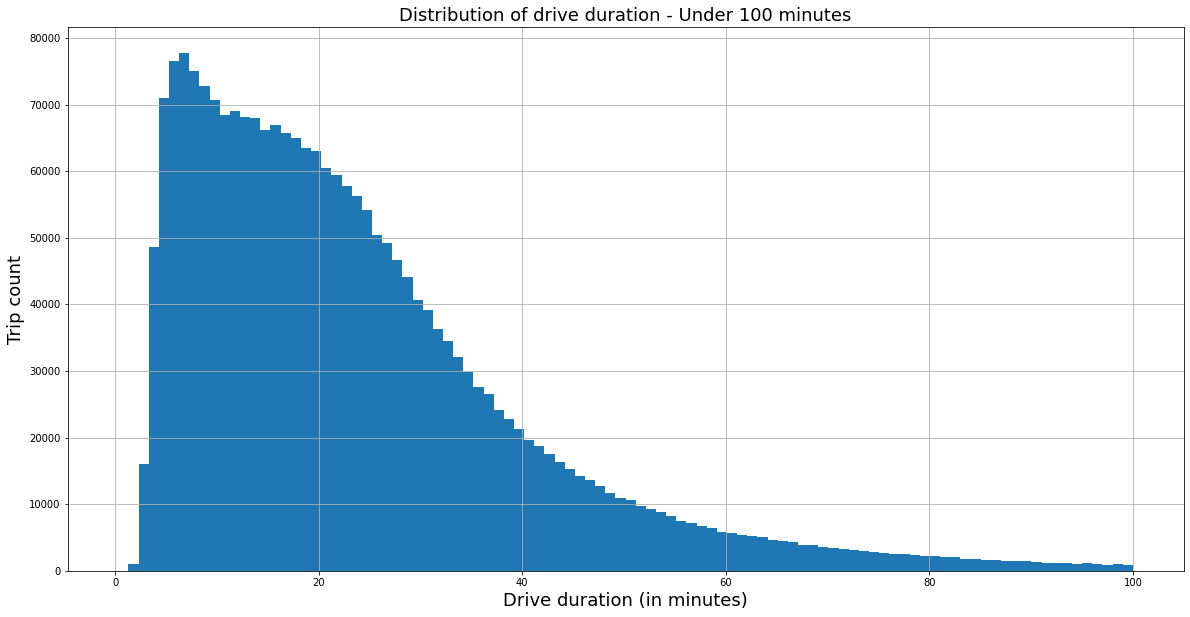

In [65]:
#Let's have a look at drive durations between 0 and 100
plotContinuousHist(dfTrips[dfTrips.tripDriveDurationInMinutes<100].tripDriveDurationInMinutes,100,
                   'Distribution of drive duration - Under 100 minutes',"Drive duration (in minutes)","Trip count")

# Drive duration vs fuel used

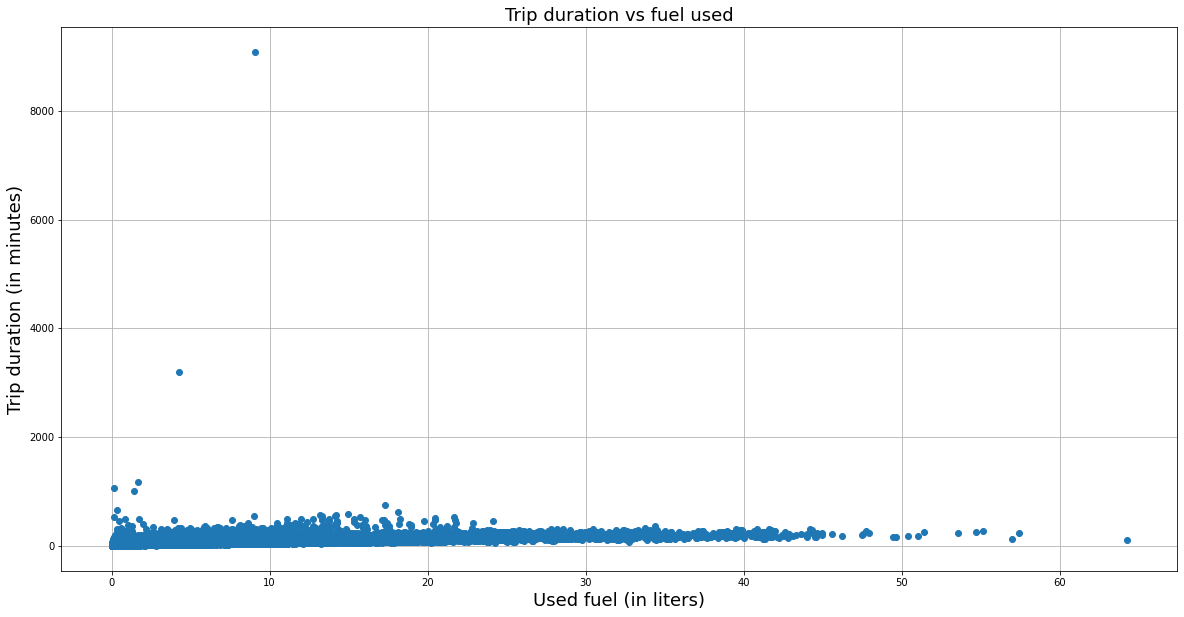

In [51]:
#Plot the fuel used by trip vs trip drive duration

#Remove the trips with NaN estimateFuelUsedInLiters
dfTripsNoNa = dfTrips.dropna(how='any')

#Takes few minutes
scatterPlot(dfTripsNoNa.tripEstimateFuelUsedInLiters,dfTripsNoNa.tripDriveDurationInMinutes,
            'Trip duration vs fuel used',"Used fuel (in liters)","Trip duration (in minutes)")

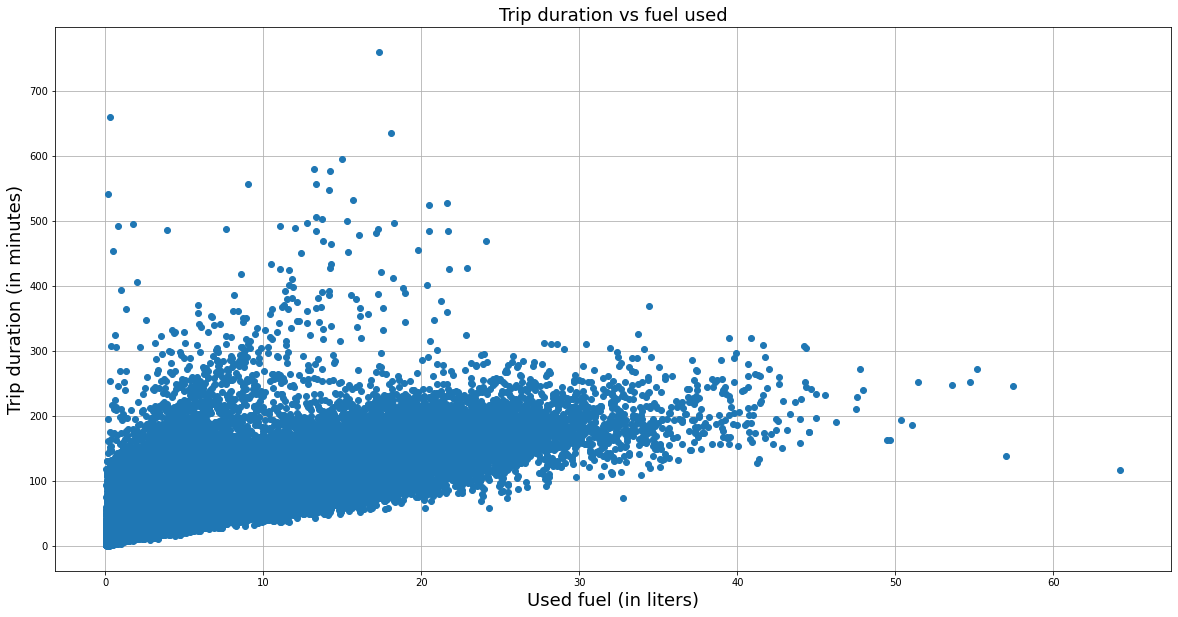

In [52]:
#There are clearly 2 outliers - with trip duration bigger than 1000 minutes = 17 hours with low consumption
#These outliers are removed
dfTripsNoNa = dfTripsNoNa[dfTripsNoNa.tripDriveDurationInMinutes <1000]

#Plot the fuel used by trip vs trip drive duration
#Takes few minutes
#The relationship is linear for a great part of the trips
scatterPlot(dfTripsNoNa.tripEstimateFuelUsedInLiters,dfTripsNoNa.tripDriveDurationInMinutes,
            'Trip duration vs fuel used',"Used fuel (in liters)","Trip duration (in minutes)")

2 different linear trends can be observed. The first one with the lowest slope corresponds to trips in the city. For these trips, the used fuel is relatively high compared to the drive duration. The trend with the highest slope corresponds to trips outside cities, where the fuel consumption by minutes is lower. 

# Number of trips by car

In [ ]:
#Count the number of trips by carId
dfTrips['count'] = 1
dfCars = dfTrips[['carId','count']].groupby('carId').sum().rename(columns={'count':'nbTripsByCar'})

In [23]:
#Average number of trips by car
print("Average number of trips by car:",np.round(dfCars.nbTripsByCar.mean(),1))

Average number of trips by car: 57.8


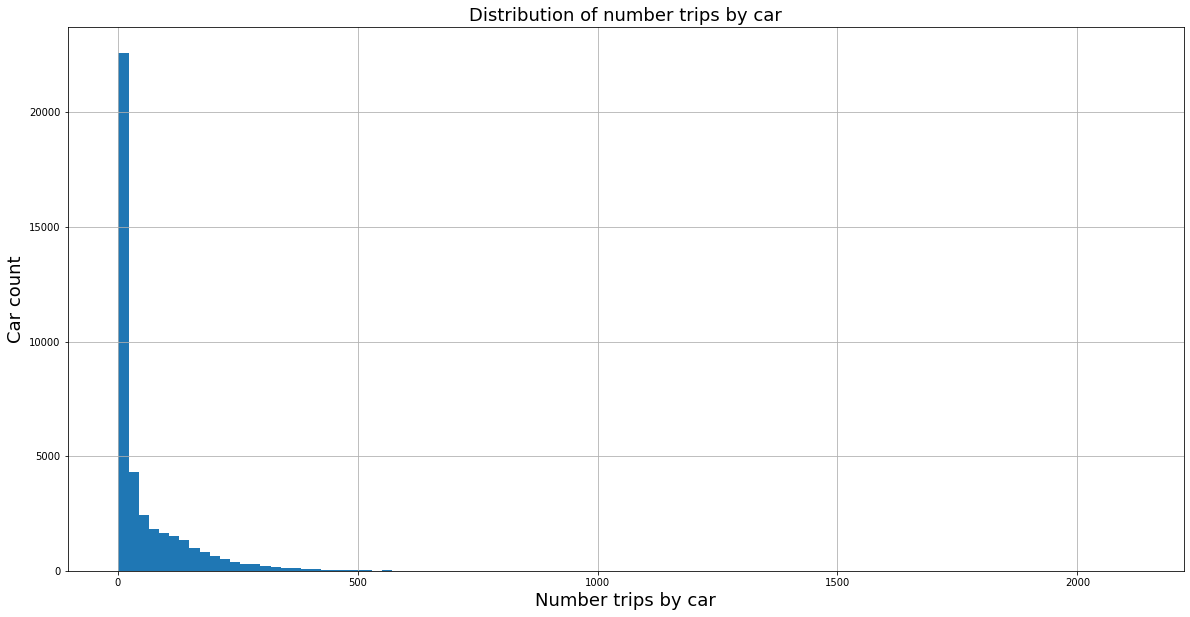

In [24]:
plotContinuousHist(dfCars.nbTripsByCar,100,
                   'Distribution of number trips by car',"Number trips by car","Car count")

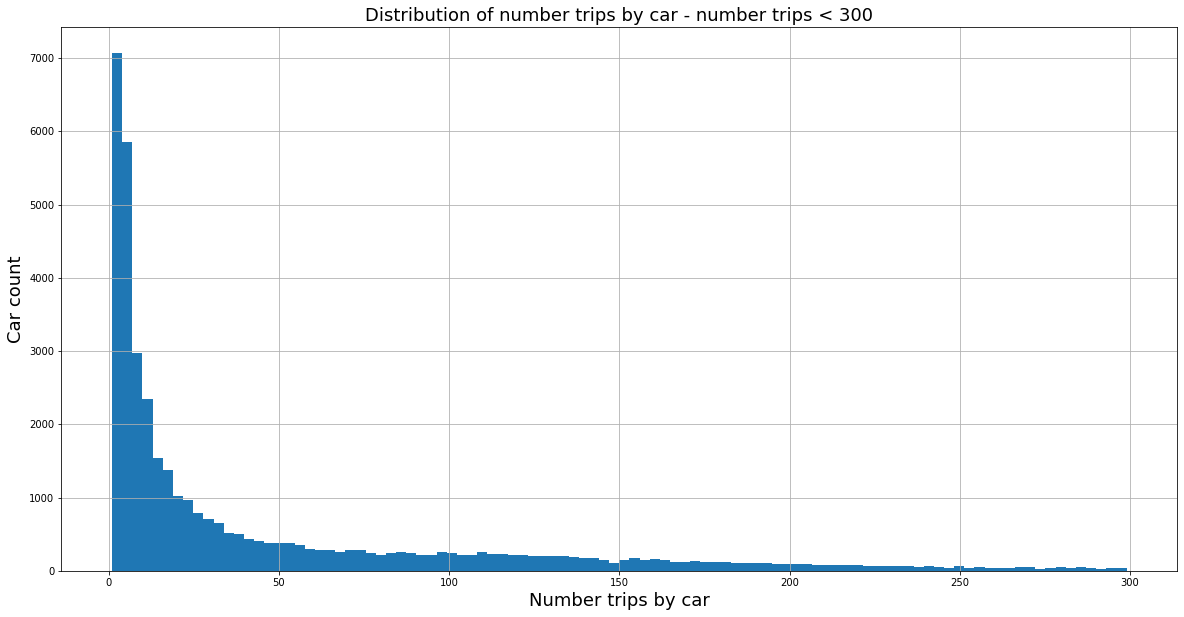

In [47]:
plotContinuousHist(dfCars[dfCars.nbTripsByCar<300].nbTripsByCar,100,
                   'Distribution of number trips by car - number trips < 300',"Number trips by car","Car count")

In [1]:
print("% of cars with less than 5 trips:", len(dfCars[dfCars.nbTripsByCar<10])/len(dfCars))

NameError: name 'dfCars' is not defined

# Find the trip distance in miles

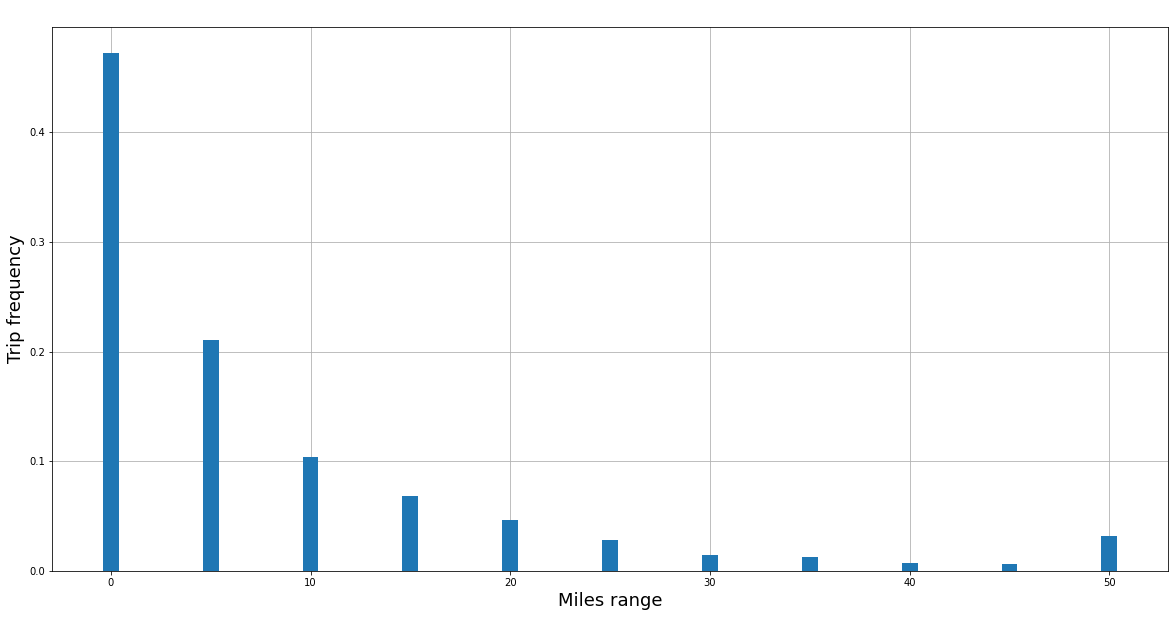

In [44]:
fileDirectory = '/mnt/sdb1/gauthier/jupyter/'
df = pd.read_pickle(fileDirectory+"data/DataModeling_Iteration4/tripStartEndPoints_Preparation2.pkl")
df['totalTravelDistanceInMiles']=df.totalTravelDistanceInKm*0.62
bins=np.linspace(0,50,11)
bins=np.append(bins,1000)
hist, _=np.histogram(df.totalTravelDistanceInMiles,bins)
plotHistogram(hist/np.sum(hist),bins[:-1],' ','Miles range','Trip frequency')

In [68]:
print("Mean distance traveled by trip:",np.mean(df.totalTravelDistanceInMiles))
print("Median distance traveled by trip:",np.median(df.totalTravelDistanceInMiles))

Mean distance traveled by trip: 10.871184
Median distance traveled by trip: 5.453443


# Time duration between 2 records

In [69]:
#Compute the mean duration between records
dfTrips['meanDurationsBetweenRecords'] = dfTrips.tripDriveDurationInMinutes / dfTrips.nbRecords 

In [70]:
#Average of the mean duration between records by trip
print("Average of the mean duration between records by trip:",
      round(np.mean(dfTrips[dfTrips.meanDurationsBetweenRecords<10000].meanDurationsBetweenRecords)*60,2),'seconds')

Average of the mean duration between records by trip: 20.21 seconds


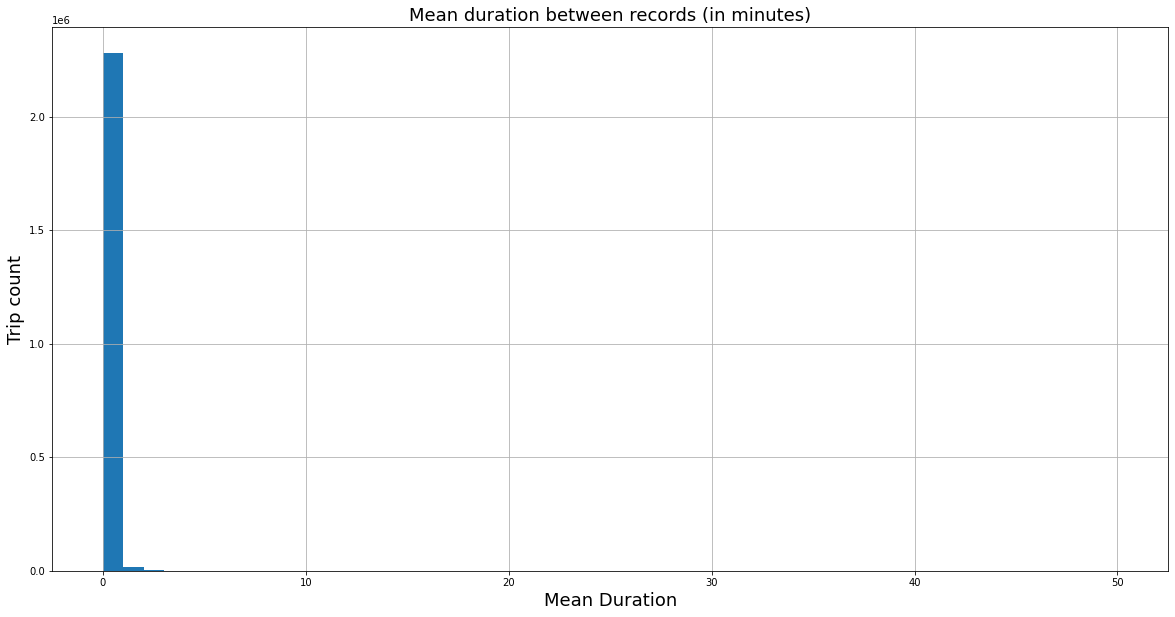

In [71]:
#Plot the distribution of mean duration between 2 records in a trip 
#Here it is supposed that the records are uniformly sampled
#The trips with high durations might be removed 
plotContinuousHist(dfTrips.meanDurationsBetweenRecords,[0,1,2,3,4,5,6,7,8,9,10,50],
                  "Mean duration between records (in minutes)","Mean Duration","Trip count")

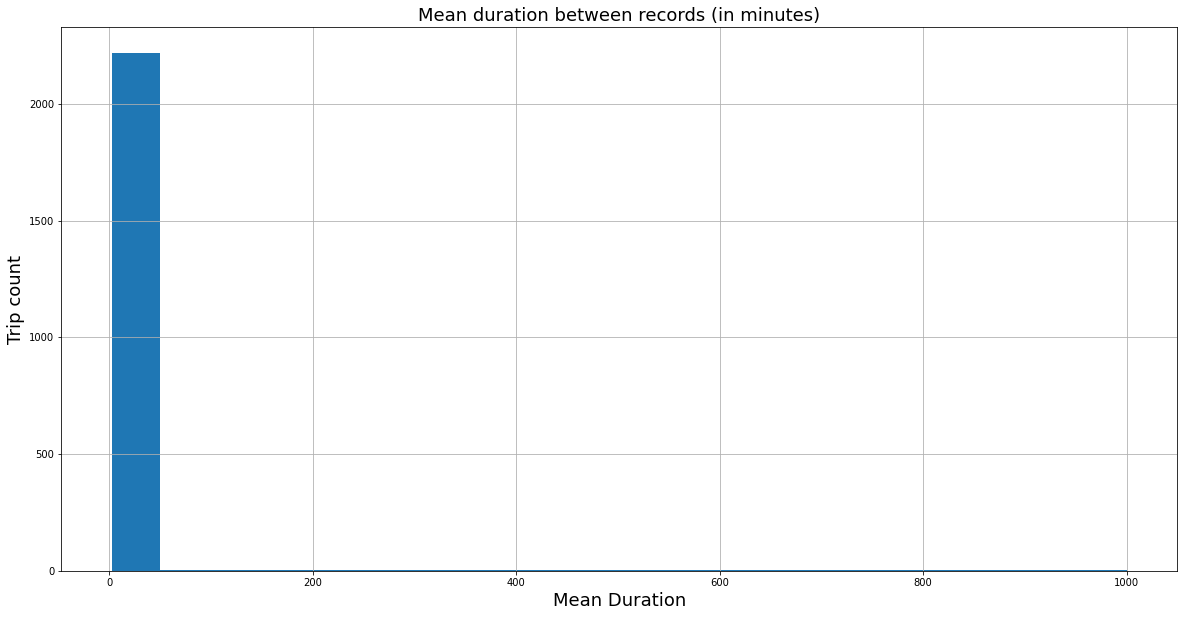

In [72]:
plotContinuousHist(dfTrips.meanDurationsBetweenRecords,[3,50,1000],
                  "Mean duration between records (in minutes)","Mean Duration","Trip count")